In [46]:
# check inspiral fit

In [47]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})

<Figure size 432x288 with 0 Axes>

In [48]:
import phenom

In [49]:
import pandas as pd
import os
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [50]:
os.sys.path.append("/Users/sebastian.khan/personal/git/stk/ml/waveforms/oct2022/uncertainty")

In [51]:
# custom module
import collocation as col

In [52]:
import sympy
# sympy.init_printing()
x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

In [53]:
# custom pn module for inspiral
import pn

In [54]:
catalogue_dir = "/Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022"

In [55]:
df = pd.read_csv(os.path.join(catalogue_dir, 'metadata.csv'))

In [56]:
times = np.load(os.path.join(catalogue_dir, 'times.npy'))

In [57]:
strains = np.load(os.path.join(catalogue_dir, 'strains.npy'))

In [58]:
df.query("q==1")

name    q     fring     fdamp  duration  t_final
18   SXS_BBH_0180_Res3  1.0  0.088087  0.013596    9359.5    236.6
20   SXS_BBH_0180_Res2  1.0  0.088087  0.013596    9354.6    236.8
22   SXS_BBH_0180_Res4  1.0  0.088087  0.013596    9270.5    236.4
27  RIT-eBBH-1090-n100  1.0  0.088087  0.013596    1493.9    362.0
31   RIT-BBH-0112-n100  1.0  0.088087  0.013596   16963.4    419.5

In [59]:
df.query("q==18")

name     q     fring    fdamp  duration  t_final
0  q18a0a0c025_96_fine  18.0  0.063334  0.01414    1020.0    465.8
6      q18a0a0c025_144  18.0  0.063334  0.01414    1028.3     88.8
8      q18a0a0c025_120  18.0  0.063334  0.01414    1027.5    174.7

In [60]:
df.query("q==32")

name     q     fring     fdamp  duration  t_final
34  RIT-BBH-0792-n120  32.0  0.061687  0.014149    1558.3    191.2
39  RIT-BBH-1025-n100  32.0  0.061687  0.014149    1474.0    240.2

In [61]:
# idx = 22 # q1
idx = 6 # q18
# idx = 34 # q32

In [62]:
x = times.copy()
y = strains[idx]

In [63]:
amp=np.abs(y)
phase=np.unwrap(np.angle(y))
freq=IUS(times, phase).derivative()(x)

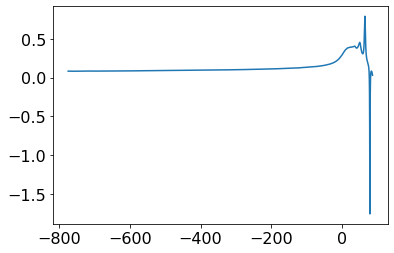

In [64]:
plt.plot(x, freq)

In [65]:
plt.plot(x, y.real)
plt.plot(x, y.imag)

In [117]:
M = 1
eta = phenom.eta_from_q(df['q'][idx])
tc = 1000
# tc = 0

In [118]:
mask_ins = (x >= x[0]) & (x <= -300)

In [119]:
x_train = x[mask_ins]
# y_train = amp[mask_ins]
y_train = freq[mask_ins]

In [208]:
base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10])
# base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10, x_sym**11, x_sym**12])
# base_ansatz = np.sum([x_sym**1, x_sym**2, x_sym**3, x_sym**4, x_sym**5])
# base_ansatz = np.sum([(x_sym**(8*3)), (x_sym**(9*3)), (x_sym**(10*3))])
# base_ansatz = np.sum([x_sym**(8-3), x_sym**(9-3), x_sym**(10-3)])
# base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8)])
# base_ansatz = np.sum([x_sym**((-8./8)+(-3./8)), x_sym**((-9./8)+(-3./8)), x_sym**((-10./8)+(-3./8))])
collocation_points = {
    0:[-700, -500, -300],
    # 1:[-700, -300],
}

In [209]:
x_sym**3

x_sym**3

In [210]:
(x_sym**3)**3

x_sym**9

In [211]:
(x_sym**(3*3))

x_sym**9

In [212]:
def T3_theta(t, tc, eta, M):
    return (eta * (tc-t) / (5 * M))**(-1/8)

In [213]:
def T3_newt(t, tc, eta, M):
    return (T3_theta(t, tc, eta, M)**3) / 8

In [214]:
pn_kwargs=dict(t=x_train, tc=tc, eta=eta, M=M)
# pn_sub_dict = {'x_sym': pn_kwargs['eta'] * (pn_kwargs['tc']-x_sym) / (5*pn_kwargs['M']) }
# theta = pn_kwargs['eta'] * (pn_kwargs['tc']-x_sym) / (5*pn_kwargs['M'])
theta = T3_theta(x_sym, pn_kwargs['tc'], pn_kwargs['eta'], pn_kwargs['M'])
pn_sub_dict = {'x_sym': theta }
# pn_sub_dict = {'x_sym': theta**3 }
ansatz = base_ansatz.subs(pn_sub_dict)

sub_dict=None

In [215]:
om_newt = T3_newt(**pn_kwargs)

In [216]:
plt.plot(x_train, om_newt)

In [217]:
ansatz

0.0564294576743002/(1 - 0.001*x_sym)**1.25 + 0.0752238035251076/(1 - 0.001*x_sym)**1.125 + 0.100277777777778/(1 - 0.001*x_sym)**1.0

In [218]:
y_pn = pn.TaylorT3_Omega_new(**pn_kwargs)
# y_pn = np.abs(pn.Hhat22_T3(**pn_kwargs))

In [219]:
plt.plot(x_train, y_pn)
plt.plot(x_train, y_train)
# plt.ylim(0, 0.1)

In [220]:
# y_residual = y_train - y_pn
y_residual = (y_train - y_pn) / om_newt

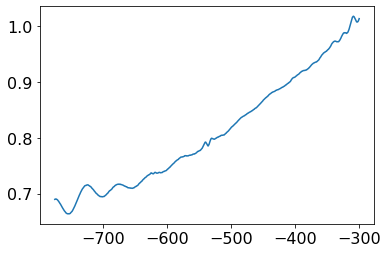

In [221]:
plt.plot(x_train, y_residual)

In [222]:
# collocation fit
# interpolate target so we can evaluate
# it and it's derivative at any x value
iy = IUS(x_train, y_residual)

# evaluate interpolant at corresponding derivative order
# and location
rhs = {}
for k in collocation_points.keys():
    v = map(iy.derivative(k), collocation_points[k])
    v = np.array(list(v))
    rhs[k] = v

# change col.CollocationModel to take as input dictionaries for
# `collocation_points` and `rhs`
# with keys that are integer and represent the order of the derivative
cm = col.CollocationModelNew(
    collocation_points=collocation_points,
    rhs=rhs,
    ansatz=ansatz,
    sub_dict=sub_dict,
)

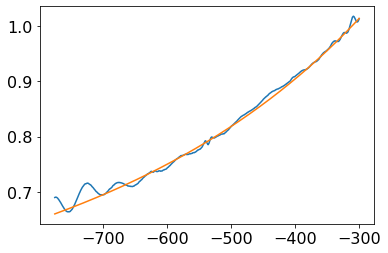

In [223]:
plt.plot(x_train, y_residual)
plt.plot(x_train, cm.predict(x_train).astype(np.float64))

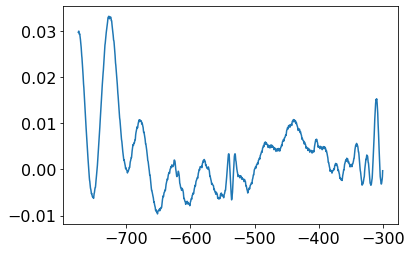

In [224]:
plt.plot(x_train, y_residual-cm.predict(x_train).astype(np.float64))

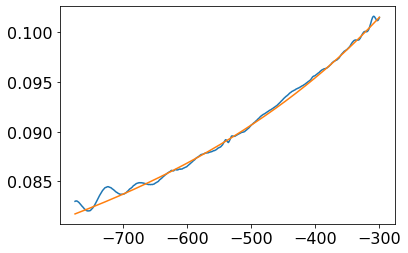

In [225]:
plt.plot(x_train, y_train)
# plt.plot(x_train, y_pn + cm.predict(x_train).astype(np.float64))
plt.plot(x_train, y_pn + om_newt * cm.predict(x_train).astype(np.float64))

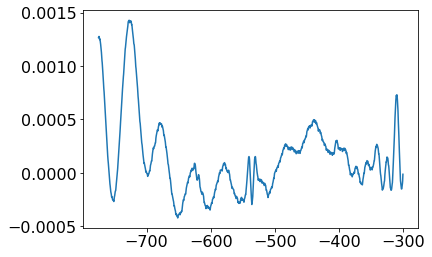

In [226]:
# plt.plot(x_train, y_train - (y_pn + cm.predict(x_train).astype(np.float64)))
plt.plot(x_train, y_train - (y_pn + om_newt * cm.predict(x_train).astype(np.float64)))

In [227]:
pn_kwargs

{'t': array([-775. , -774.9, -774.8, ..., -300.3, -300.2, -300.1]),
 'tc': 1000,
 'eta': 0.04986149584487535,
 'M': 1}

In [228]:


x_new = np.arange(-1000, -100, 1)

om_newt_new = T3_newt(t=x_new, tc=tc, eta=eta, M=M)

y_pn = pn.TaylorT3_Omega_new(t=x_new, tc=tc, eta=eta, M=M)
y_res_hat = cm.predict(x_new).astype(np.float64)
plt.plot(x_train, y_train, label='nr')
plt.plot(x_new, y_pn, label='pn')
# plt.plot(x_new, y_pn + y_res_hat, ls='--', label='model')
plt.plot(x_new, y_pn + om_newt_new*y_res_hat, ls='--', label='model')
# plt.yscale('log')
plt.ylim(0, 0.15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"q = {phenom.q_from_eta(eta)}")

Text(0.5, 1.0, 'q = 18.0')

Text(0.5, 1.0, 'q = 18.0')

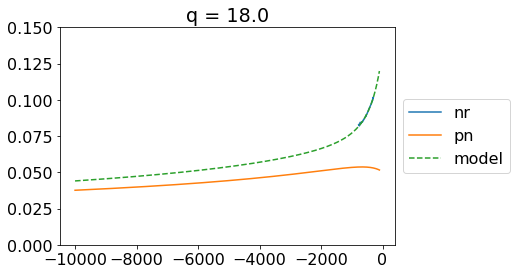

In [229]:


x_new = np.arange(-10000, -100, 1)
om_newt_new = T3_newt(t=x_new, tc=tc, eta=eta, M=M)
y_pn = pn.TaylorT3_Omega_new(t=x_new, tc=tc, eta=eta, M=M)
y_res_hat = cm.predict(x_new).astype(np.float64)
plt.plot(x_train, y_train, label='nr')
plt.plot(x_new, y_pn, label='pn')
# plt.plot(x_new, y_pn + y_res_hat, ls='--', label='model')
plt.plot(x_new, y_pn + om_newt_new*y_res_hat, ls='--', label='model')
# plt.yscale('log')
plt.ylim(0, 0.15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"q = {phenom.q_from_eta(eta)}")